<a href="https://colab.research.google.com/github/16A0/til/blob/master/GLIDE_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

based on woctezuma's Colab

edits by @nev#4905

2021/12/21: added non-square resolution, colab forms

2021/12/31: added fine-tuning

References:
- https://github.com/openai/glide-text2im
- https://github.com/woctezuma/glide-text2im-colab

### Install package

In [ ]:
!git clone https://github.com/openai/glide-text2im.git
%cd glide-text2im
!pip install -q -e .

Cloning into 'glide-text2im'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 66 (delta 23), reused 33 (delta 14), pack-reused 10
Unpacking objects: 100% (66/66), done.
/content/glide-text2im
     |████████████████████████████████| 64 kB 1.8 MB/s 


### Set-up functions, models and options

In [ ]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [ ]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
fp16 = False
device = th.device('cpu' if not has_cuda else 'cuda')

In [ ]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda and fp16
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda and fp16:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385030726


In [ ]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda and fp16
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda and fp16:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


In [ ]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

### Input **your** text prompt

In [ ]:
#@title resolution settings

#@markdown the resolution goes up to 192x128 on a 12GB K80. it takes 2 minutes to generate at 128x64 and 10 for 256x128.

#@markdown the final resolution of the image after upsampling will be 4x higher 

side_x = 64  #@param {type: "integer"}
side_y =   64#@param {type: "integer"}
upsample_x = 4  #@param {type: "integer"}

### Fine-tuning

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  


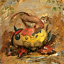

In [ ]:
#@title image to tune with
import torch
import requests
import numpy as np
from PIL import Image


preprocess = lambda x: torch.from_numpy(np.asarray(x.resize((side_x, side_y)).convert("RGB"))).unsqueeze(0).permute(0, 3, 1, 2).to(device) / 127. - 1.
download = lambda x: preprocess(Image.open(requests.get(x, stream=True).raw))
img_path = "https://cdn.discordapp.com/attachments/730484623028519072/926386737167622175/unknown.png" #@param ["https://cdn.discordapp.com/attachments/869675061211181107/924292876601540638/Title.jpg", "https://cdn.discordapp.com/attachments/730484623028519072/926386737167622175/unknown.png"] {type: "string", allow-input: true} 
t = download(img_path)
t.shape
show_images(t)

In [ ]:
#@title training
from tqdm import trange, tqdm

import gc
from ipywidgets import Output
from IPython.display import display
from matplotlib import pyplot as plt
from IPython.display import clear_output


gc.collect()
torch.cuda.empty_cache()
learning_rate = 2e-5  #@param {type: "number"}
model.requires_grad_(True)
optim = th.optim.Adam([x for x in model.parameters() if x.requires_grad], lr=learning_rate)
batch_size = 2  #@param {type: "integer"}
grad_acc = 4  #@param {type: "integer"}
train_steps = 50  #@param {type: "integer"}
# prompts disabled
# # Create the text tokens to feed to the model.
# tokens = model.tokenizer.encode(prompt)
# tokens, mask = model.tokenizer.padded_tokens_and_mask(
#     tokens, options['text_ctx']
# )
# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size  # * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        # [tokens] * batch_size + 
        [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        # [mask] * batch_size + 
        [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)
x = t.detach().clone().repeat((full_batch_size, 1, 1, 1))


def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.
    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    # print(arr.shape, timesteps.shape)
    res = th.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    # res = th.gather(res, 0, timesteps)
    # print(res.shape, timesteps.shape)# [timesteps].float()
    # print("before while")
    # return
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


out = Output()
display(out)
losses = []
bar = trange(train_steps)
l = 0
try:
    for i in bar:
        ts = torch.randint(0, 99, (full_batch_size,)).to(x.device)
        noise_variance = _extract_into_tensor(diffusion.betas, ts, x.shape)
        orig_noise = th.randn_like(x, device=x.device)
        noise = (noise_variance ** 0.5).to(x.device) * orig_noise
        output = model(x + noise, ts * 10, **model_kwargs)
        eps = output[..., :3, :, :]
        loss = th.nn.functional.mse_loss(eps, orig_noise)
        l += loss.item()
        loss.backward()
        if i % grad_acc == grad_acc - 1:
            optim.step()
            optim.zero_grad()
            l /= grad_acc
            bar.set_description(f"loss: {l}")
            losses.append(l)
            l = 0
            with out:
                clear_output()
                plt.plot(losses)
                plt.show()
except KeyboardInterrupt:
    pass

Output()

loss: 0.5442173704504967: 100%|██████████| 50/50 [01:37<00:00,  1.95s/it]


### Sample at your resolution

In [ ]:
#@title sampling parameters
prompt = "an landscape painting of switzerland" #@param {type: "string", allow-input: true} ["an landscape painting of switzerland", "an oil painting of a cat"]

batch_size = 1  #@param {type: "integer"}
guidance_scale = 3.0  #@param {type: "number"}

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997  #@param {type: "number"}

In [ ]:
##############################
#@title Sample from the base model #
##############################
import torch

out = Output()
display(out)

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)


# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    # print(ts)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    beta = diffusion.betas[ts.flatten()[0].item() // 10]
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    with out:
        clear_output()
        show_images((x_t - eps * (beta ** 0.5))[:batch_size])
    return th.cat([eps, rest], dim=1)

# Sample from the base model.
model.del_cache()
with torch.inference_mode():
    samples = diffusion.p_sample_loop(
        model_fn,
        (full_batch_size, 3, side_y, side_x),  # only thing that's changed
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
model.del_cache()

Output()

  0%|          | 0/100 [00:00<?, ?it/s]

### Show the output

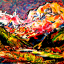

In [ ]:
show_images(samples)

### Upsample to 4x resolution

In [ ]:
##############################
#@title Upsample the low-res images #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, side_y * upsample_x, side_x * upsample_x)
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

  0%|          | 0/27 [00:00<?, ?it/s]

### Show the output

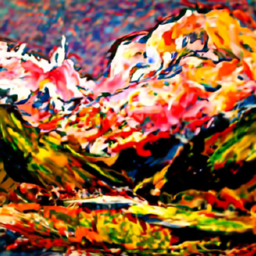

In [ ]:
show_images(up_samples)

the end